# Experiment: MSFT 1-Minute GRU Forecast (Trend-Aware v7.1)

Key changes for trend-aware features:
1. Multi-timeframe trend indicators:
   - 5-minute EMA slope (resampled and broadcast to 1-min)
   - 20-bar momentum: (Close[t] - Close[t-20]) / Close[t-20]
   - RSI(14) on 1-minute closes
2. DIR_PENALTY_WEIGHT = 2.0 (heavily punish wrong direction predictions)
3. Probabilistic outputs (mu + sigma) with temperature control
4. Autoregressive recursive generation with candle validity enforcement

## Package Installation & Imports

In [1]:
import importlib.util
import subprocess
import sys

required = {
    'alpaca': 'alpaca-py',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'pandas_market_calendars': 'pandas-market-calendars',
}
missing = [pkg for mod, pkg in required.items() if importlib.util.find_spec(mod) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
else:
    print('All required third-party packages are already installed.')

All required third-party packages are already installed.


In [2]:
from __future__ import annotations
import copy
import os
import random
import time
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import torch
import torch.nn as nn
from alpaca.data.enums import DataFeed
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import DataLoader, Dataset

## Random Seed & Device Setup

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3070


## Configuration

In [4]:
# Data Configuration
SYMBOL = 'MSFT'
LOOKBACK_DAYS = 120
OHLC_COLS = ['Open', 'High', 'Low', 'Close']
RAW_COLS = OHLC_COLS + ['Volume', 'TradeCount', 'VWAP']
BASE_FEATURE_COLS = [
    'rOpen', 'rHigh', 'rLow', 'rClose',
    'logVolChange', 'logTradeCountChange',
    'vwapDelta', 'rangeFrac', 'orderFlowProxy', 'tickPressure',
    # NEW: Trend-aware features
    'ema5Slope', 'momentum20', 'rsi14',
]
TARGET_COLS = ['rOpen', 'rHigh', 'rLow', 'rClose']
INPUT_EXTRA_COL = 'imputedFracWindow'

HORIZON = 15
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
LOOKBACK_CANDIDATES = [64, 96, 160, 256]
DEFAULT_LOOKBACK = 96
ENABLE_LOOKBACK_SWEEP = True
SKIP_OPEN_BARS_TARGET = 6

In [5]:
# Model Configuration
HIDDEN_SIZE = 256  # Increased for better generation capacity
NUM_LAYERS = 2
DROPOUT = 0.20     # Slightly higher for stochasticity
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 256

In [6]:
# Training Configuration
SWEEP_MAX_EPOCHS = 15
SWEEP_PATIENCE = 5
FINAL_MAX_EPOCHS = 60  # More epochs for convergence
FINAL_PATIENCE = 12
TF_START = 1.0
TF_END = 0.0
TF_DECAY_RATE = 0.95

In [7]:
# Loss Configuration
RANGE_LOSS_WEIGHT = 0.3
VOLATILITY_WEIGHT = 0.5  # Encourage proper volatility
DIR_PENALTY_WEIGHT = 2.0  # v7.1: INCREASED from 0.1 to heavily punish wrong direction
STEP_LOSS_POWER = 1.5

In [8]:
# Inference Configuration
SAMPLING_TEMPERATURE = 1.5  # >1.0 = more volatile/wild, <1.0 = conservative
VOLATILITY_SCALING = True   # Match recent realized vol
MIN_PREDICTED_VOL = 0.0001  # Minimum volatility to prevent flat lines

In [9]:
# Data Processing Configuration
STANDARDIZE_TARGETS = False
APPLY_CLIPPING = True
CLIP_QUANTILES = (0.001, 0.999)
DIRECTION_EPS = 0.0001
STD_RATIO_TARGET_MIN = 0.3

In [10]:
# Alpaca API Configuration
ALPACA_FEED = os.getenv('ALPACA_FEED', 'iex').strip().lower()
SESSION_TZ = 'America/New_York'
REQUEST_CHUNK_DAYS = 5
MAX_REQUESTS_PER_MINUTE = 120
MAX_RETRIES = 5
MAX_SESSION_FILL_RATIO = 0.15

In [11]:
# Print Configuration Summary
print({
    'symbol': SYMBOL,
    'lookback_days': LOOKBACK_DAYS,
    'horizon': HORIZON,
    'sampling_temperature': SAMPLING_TEMPERATURE,
    'loss_weights': {
        'range': RANGE_LOSS_WEIGHT,
        'volatility': VOLATILITY_WEIGHT,
        'dir_penalty': DIR_PENALTY_WEIGHT,
    },
    'trend_features': ['ema5Slope', 'momentum20', 'rsi14'],
    'device': str(DEVICE),
})

{'symbol': 'MSFT', 'lookback_days': 120, 'horizon': 15, 'sampling_temperature': 1.5, 'loss_weights': {'range': 0.3, 'volatility': 0.5, 'dir_penalty': 2.0}, 'trend_features': ['ema5Slope', 'momentum20', 'rsi14'], 'device': 'cuda'}


## Data Fetching Functions

In [12]:
class RequestPacer:
    def __init__(self, max_calls_per_minute: int):
        if max_calls_per_minute <= 0:
            raise ValueError('max_calls_per_minute must be >0')
        self.min_interval = 60.0 / float(max_calls_per_minute)
        self.last_call_ts = 0.0
        
    def wait(self) -> None:
        now = time.monotonic()
        elapsed = now - self.last_call_ts
        if elapsed < self.min_interval:
            time.sleep(self.min_interval - elapsed)
        self.last_call_ts = time.monotonic()

In [13]:
def _require_alpaca_credentials() -> tuple[str, str]:
    api_key = os.getenv('ALPACA_API_KEY')
    secret_key = os.getenv('ALPACA_SECRET_KEY')
    if not api_key or not secret_key:
        raise RuntimeError('Missing ALPACA_API_KEY / ALPACA_SECRET_KEY.')
    return api_key, secret_key

def _resolve_feed(feed_name: str) -> DataFeed:
    mapping = {'iex': DataFeed.IEX, 'sip': DataFeed.SIP, 'delayed_sip': DataFeed.DELAYED_SIP}
    k = feed_name.strip().lower()
    if k not in mapping:
        raise ValueError(f'Unsupported ALPACA_FEED={feed_name!r}. Use one of: {list(mapping)}')
    return mapping[k]

In [14]:
def fetch_bars_alpaca(symbol: str, lookback_days: int) -> tuple[pd.DataFrame, int]:
    api_key, secret_key = _require_alpaca_credentials()
    client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)
    feed = _resolve_feed(ALPACA_FEED)
    pacer = RequestPacer(MAX_REQUESTS_PER_MINUTE)
    
    end_ts = datetime.now(timezone.utc).replace(second=0, microsecond=0)
    if ALPACA_FEED in {'sip', 'delayed_sip'}:
        end_ts = end_ts - timedelta(minutes=20)
    start_ts = end_ts - timedelta(days=lookback_days)
    
    parts = []
    cursor = start_ts
    calls = 0
    
    while cursor < end_ts:
        chunk_end = min(cursor + timedelta(days=REQUEST_CHUNK_DAYS), end_ts)
        chunk = None
        for attempt in range(1, MAX_RETRIES + 1):
            pacer.wait()
            calls += 1
            try:
                req = StockBarsRequest(
                    symbol_or_symbols=[symbol],
                    timeframe=TimeFrame.Minute,
                    start=cursor,
                    end=chunk_end,
                    feed=feed,
                    limit=10000,
                )
                chunk = client.get_stock_bars(req).df
                break
            except Exception as exc:
                msg = str(exc).lower()
                if ('429' in msg or 'rate limit' in msg) and attempt < MAX_RETRIES:
                    backoff = min(2 ** attempt, 30)
                    print(f'Rate-limited; sleeping {backoff}s (attempt {attempt}/{MAX_RETRIES}).')
                    time.sleep(backoff)
                    continue
                if ('subscription' in msg or 'forbidden' in msg) and ALPACA_FEED != 'iex':
                    raise RuntimeError('Feed unavailable for account. Use ALPACA_FEED=iex or upgrade subscription.') from exc
                raise
        if chunk is not None and not chunk.empty:
            d = chunk.reset_index().rename(columns={
                'timestamp': 'Datetime', 'open': 'Open', 'high': 'High',
                'low': 'Low', 'close': 'Close', 'volume': 'Volume',
                'trade_count': 'TradeCount', 'vwap': 'VWAP',
            })
            if 'Volume' not in d.columns:
                d['Volume'] = 0.0
            if 'TradeCount' not in d.columns:
                d['TradeCount'] = 0.0
            if 'VWAP' not in d.columns:
                d['VWAP'] = d['Close']
            
            need = ['Datetime'] + RAW_COLS
            d['Datetime'] = pd.to_datetime(d['Datetime'], utc=True)
            d = d[need].dropna(subset=OHLC_COLS).set_index('Datetime').sort_index()
            parts.append(d)
        cursor = chunk_end
    
    if not parts:
        raise RuntimeError('No bars returned from Alpaca.')
    out = pd.concat(parts, axis=0).sort_index()
    out = out[~out.index.duplicated(keep='last')]
    return out.astype(np.float32), calls

In [15]:
def sessionize_with_calendar(df_utc: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    if df_utc.empty:
        raise RuntimeError('Input bars are empty.')
    
    idx = pd.DatetimeIndex(df_utc.index)
    if idx.tz is None:
        idx = idx.tz_localize('UTC')
    else:
        idx = idx.tz_convert('UTC')
    
    df_utc = df_utc.copy()
    df_utc.index = idx
    
    cal = mcal.get_calendar('XNYS')
    sched = cal.schedule(
        start_date=(idx.min() - pd.Timedelta(days=2)).date(),
        end_date=(idx.max() + pd.Timedelta(days=2)).date(),
    )
    
    pieces = []
    fill_ratios = []
    
    for sid, (_, row) in enumerate(sched.iterrows()):
        open_ts = pd.Timestamp(row['market_open'])
        close_ts = pd.Timestamp(row['market_close'])
        
        if open_ts.tzinfo is None:
            open_ts = open_ts.tz_localize('UTC')
        else:
            open_ts = open_ts.tz_convert('UTC')
        if close_ts.tzinfo is None:
            close_ts = close_ts.tz_localize('UTC')
        else:
            close_ts = close_ts.tz_convert('UTC')
            
        exp_idx = pd.date_range(open_ts, close_ts, freq='1min', inclusive='left')
        if len(exp_idx) == 0:
            continue
            
        day = df_utc[(df_utc.index >= open_ts) & (df_utc.index < close_ts)]
        day = day.reindex(exp_idx)
        imputed = day[OHLC_COLS].isna().any(axis=1).to_numpy()
        fill_ratio = float(imputed.mean())
        
        if fill_ratio >= 1.0 or fill_ratio > MAX_SESSION_FILL_RATIO:
            continue
            
        day[OHLC_COLS + ['VWAP']] = day[OHLC_COLS + ['VWAP']].ffill().bfill()
        if day['VWAP'].isna().all():
            day['VWAP'] = day['Close']
        else:
            day['VWAP'] = day['VWAP'].fillna(day['Close'])
            
        day['Volume'] = day['Volume'].fillna(0.0)
        day['TradeCount'] = day['TradeCount'].fillna(0.0)
        day['is_imputed'] = imputed.astype(np.int8)
        day['session_id'] = int(sid)
        day['bar_in_session'] = np.arange(len(day), dtype=np.int32)
        day['session_len'] = int(len(day))
        
        if day[RAW_COLS].isna().any().any():
            raise RuntimeError('NaNs remain after per-session fill.')
        pieces.append(day)
        fill_ratios.append(fill_ratio)
    
    if not pieces:
        raise RuntimeError('No sessions kept after calendar filtering.')
        
    out = pd.concat(pieces, axis=0).sort_index()
    out.index = out.index.tz_convert(SESSION_TZ).tz_localize(None)
    out = out.copy()
    
    for c in RAW_COLS:
        out[c] = out[c].astype(np.float32)
    out['is_imputed'] = out['is_imputed'].astype(np.int8)
    out['session_id'] = out['session_id'].astype(np.int32)
    out['bar_in_session'] = out['bar_in_session'].astype(np.int32)
    out['session_len'] = out['session_len'].astype(np.int32)
    
    meta = {
        'calendar_sessions_total': int(len(sched)),
        'kept_sessions': int(len(pieces)),
        'avg_fill_ratio_kept': float(np.mean(fill_ratios)) if fill_ratios else float('nan'),
    }
    return out, meta

## Fetch Data from Alpaca

In [16]:
raw_df_utc, api_calls = fetch_bars_alpaca(SYMBOL, LOOKBACK_DAYS)
price_df, session_meta = sessionize_with_calendar(raw_df_utc)
print(f'Raw rows from Alpaca: {len(raw_df_utc):,}')
print(f'Sessionized rows kept: {len(price_df):,}')
print('Session meta:', session_meta)

min_needed = max(LOOKBACK_CANDIDATES) + HORIZON + 1000
if len(price_df) < min_needed:
    raise RuntimeError(f'Not enough rows after session filtering ({len(price_df)}). Need at least {min_needed}.')

Raw rows from Alpaca: 31,193
Sessionized rows kept: 30,840
Session meta: {'calendar_sessions_total': 84, 'kept_sessions': 80, 'avg_fill_ratio_kept': 0.010086996336996338}


## Feature Engineering Functions (v7.1 with Trend Indicators)

In [17]:
def enforce_candle_validity(ohlc: np.ndarray) -> np.ndarray:
    out = np.asarray(ohlc, dtype=np.float32)
    o, h, l, c = out[:, 0], out[:, 1], out[:, 2], out[:, 3]
    out[:, 1] = np.maximum.reduce([h, o, c])
    out[:, 2] = np.minimum.reduce([l, o, c])
    return out

def returns_to_prices_seq(return_ohlc: np.ndarray, last_close: float) -> np.ndarray:
    seq = []
    prev_close = float(last_close)
    for rO, rH, rL, rC in np.asarray(return_ohlc, dtype=np.float32):
        o = prev_close * np.exp(float(rO))
        h = prev_close * np.exp(float(rH))
        l = prev_close * np.exp(float(rL))
        c = prev_close * np.exp(float(rC))
        cand = enforce_candle_validity(np.array([[o, h, l, c]], dtype=np.float32))[0]
        seq.append(cand)
        prev_close = float(cand[3])
    return np.asarray(seq, dtype=np.float32)

In [18]:
def calc_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    """Calculate RSI for a price series."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    
    # Use exponential moving average for smoother RSI
    avg_gain = gain.ewm(span=period, min_periods=period).mean()
    avg_loss = loss.ewm(span=period, min_periods=period).mean()
    
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def calc_ema5_slope(df_1min: pd.DataFrame) -> pd.Series:
    """
    Calculate 5-minute EMA slope:
    1. Resample to 5-min bars (using last Close)
    2. Calculate EMA(12) on 5-min bars
    3. Calculate slope (difference between consecutive EMA values)
    4. Broadcast back to 1-min index via forward-fill
    """
    # Resample to 5-minute bars using Close
    close_5min = df_1min['Close'].resample('5min', label='right', closed='right').last()
    
    # Calculate EMA on 5-min data
    ema_5min = close_5min.ewm(span=12, min_periods=12).mean()
    
    # Calculate slope (rate of change)
    ema_slope_5min = ema_5min.diff() / (ema_5min.shift(1) + 1e-9)
    
    # Reindex back to 1-min by forward-filling
    ema_slope_1min = ema_slope_5min.reindex(df_1min.index, method='ffill')
    
    return ema_slope_1min.fillna(0.0)

def calc_momentum20(series: pd.Series) -> pd.Series:
    """
    Calculate 20-bar momentum: (Close[t] - Close[t-20]) / Close[t-20]
    """
    momentum = (series - series.shift(20)) / (series.shift(20) + 1e-9)
    return momentum

In [19]:
def build_feature_frame(df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-9
    g = df.groupby('session_id', sort=False)
    prev_close = g['Close'].shift(1)
    prev_close = prev_close.fillna(df['Open'])
    prev_vol = g['Volume'].shift(1).fillna(df['Volume'])
    prev_tc = g['TradeCount'].shift(1).fillna(df['TradeCount'])
    prev_imp = g['is_imputed'].shift(1).fillna(0).astype(bool)
    
    row_imputed = (df['is_imputed'].astype(bool) | prev_imp)
    row_open_skip = (df['bar_in_session'].astype(int) < SKIP_OPEN_BARS_TARGET)
    
    out = pd.DataFrame(index=df.index, dtype=np.float32)
    out['rOpen'] = np.log(df['Open'] / (prev_close + eps))
    out['rHigh'] = np.log(df['High'] / (prev_close + eps))
    out['rLow'] = np.log(df['Low'] / (prev_close + eps))
    out['rClose'] = np.log(df['Close'] / (prev_close + eps))
    out['logVolChange'] = np.log((df['Volume'] + 1.0) / (prev_vol + 1.0))
    out['logTradeCountChange'] = np.log((df['TradeCount'] + 1.0) / (prev_tc + 1.0))
    out['vwapDelta'] = np.log((df['VWAP'] + eps) / (df['Close'] + eps))
    out['rangeFrac'] = np.maximum(out['rHigh'] - out['rLow'], 0) / (np.abs(out['rClose']) + eps)
    
    signed_body = (df['Close'] - df['Open']) / ((df['High'] - df['Low']) + eps)
    out['orderFlowProxy'] = signed_body * np.log1p(df['Volume'])
    out['tickPressure'] = np.sign(df['Close'] - df['Open']) * np.log1p(df['TradeCount'])
    
    # v7.1: NEW TREND-AWARE FEATURES
    # 1. 5-minute EMA slope (broadcast from 5-min to 1-min)
    out['ema5Slope'] = calc_ema5_slope(df).astype(np.float32)
    
    # 2. 20-bar momentum
    out['momentum20'] = calc_momentum20(df['Close']).astype(np.float32)
    
    # 3. RSI(14) on 1-minute closes
    rsi_raw = calc_rsi(df['Close'], period=14)
    # Normalize RSI to [-1, 1] range for better neural network training
    out['rsi14'] = ((rsi_raw - 50.0) / 50.0).fillna(0.0).astype(np.float32)
    
    out['row_imputed'] = row_imputed.astype(np.int8).to_numpy()
    out['row_open_skip'] = row_open_skip.astype(np.int8).to_numpy()
    out['prev_close'] = prev_close.astype(np.float32).to_numpy()
    return out.astype(np.float32)

def build_target_frame(feat_df: pd.DataFrame) -> pd.DataFrame:
    return feat_df[TARGET_COLS].copy().astype(np.float32)

In [20]:
feat_df = build_feature_frame(price_df)
target_df = build_target_frame(feat_df)
print('Feature rows:', len(feat_df))
print('Feature columns:', list(feat_df.columns))
print('Target columns:', list(target_df.columns))

# Print trend feature stats
print('\nTrend Feature Statistics:')
for col in ['ema5Slope', 'momentum20', 'rsi14']:
    print(f'  {col}: mean={feat_df[col].mean():.6f}, std={feat_df[col].std():.6f}')

Feature rows: 30840
Feature columns: ['rOpen', 'rHigh', 'rLow', 'rClose', 'logVolChange', 'logTradeCountChange', 'vwapDelta', 'rangeFrac', 'orderFlowProxy', 'tickPressure', 'ema5Slope', 'momentum20', 'rsi14', 'row_imputed', 'row_open_skip', 'prev_close']
Target columns: ['rOpen', 'rHigh', 'rLow', 'rClose']

Trend Feature Statistics:
  ema5Slope: mean=-0.000041, std=0.001631
  momentum20: mean=-0.000163, std=0.004175
  rsi14: mean=-0.002069, std=0.329854


## Windowing & Dataset Functions

In [21]:
def split_points(n_rows: int) -> tuple[int, int]:
    tr = int(n_rows * TRAIN_RATIO)
    va = int(n_rows * (TRAIN_RATIO + VAL_RATIO))
    return tr, va

def build_walkforward_slices(price_df_full: pd.DataFrame) -> list[tuple[str, int, int]]:
    n = len(price_df_full)
    span = int(round(n * 0.85))
    shift = max(1, n - span)
    cands = [('slice_1', 0, min(span, n)), ('slice_2', shift, min(shift + span, n))]
    out = []
    seen = set()
    for name, a, b in cands:
        key = (a, b)
        if key in seen or b - a < max(LOOKBACK_CANDIDATES) + HORIZON + 1400:
            continue
        out.append((name, a, b))
        seen.add(key)
    return out if out else [('full', 0, n)]

In [22]:
def make_multistep_windows(input_scaled, target_scaled, target_raw, row_imputed, row_open_skip, 
                           starts_prev_close, window, horizon):
    X, y_s, y_r, starts, prev_close = [], [], [], [], []
    dropped_target_imputed, dropped_target_open_skip = 0, 0
    n = len(input_scaled)
    
    for i in range(window, n - horizon + 1):
        if row_imputed[i:i+horizon].any():
            dropped_target_imputed += 1
            continue
        if row_open_skip[i:i+horizon].any():
            dropped_target_open_skip += 1
            continue
            
        xb = input_scaled[i-window:i]
        imp_frac = float(row_imputed[i-window:i].mean())
        imp_col = np.full((window, 1), imp_frac, dtype=np.float32)
        xb_aug = np.concatenate([xb, imp_col], axis=1)
        
        X.append(xb_aug)
        y_s.append(target_scaled[i:i+horizon])
        y_r.append(target_raw[i:i+horizon])
        starts.append(i)
        prev_close.append(starts_prev_close[i])
    
    return (np.asarray(X, dtype=np.float32), np.asarray(y_s, dtype=np.float32),
            np.asarray(y_r, dtype=np.float32), np.asarray(starts, dtype=np.int64),
            np.asarray(prev_close, dtype=np.float32), dropped_target_imputed, dropped_target_open_skip)

In [23]:
class MultiStepDataset(Dataset):
    def __init__(self, X, y_s, y_r):
        self.X = torch.from_numpy(X).float()
        self.y_s = torch.from_numpy(y_s).float()
        self.y_r = torch.from_numpy(y_r).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_s[idx], self.y_r[idx]

In [24]:
slices = build_walkforward_slices(price_df)
print('Walk-forward slices:', slices)

Walk-forward slices: [('slice_1', 0, 26214), ('slice_2', 4626, 30840)]


## Model Definition

In [25]:
class Seq2SeqAttnGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout, horizon):
        super().__init__()
        self.horizon = horizon
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        self.encoder = nn.GRU(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.decoder_cell = nn.GRUCell(output_size + hidden_size, hidden_size)
        self.attn_proj = nn.Linear(hidden_size, hidden_size, bias=False)
        
        # Output mu and log_sigma for each OHLC
        self.mu_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )
        self.log_sigma_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size // 2),
            nn.GELU(),
            nn.Linear(hidden_size // 2, output_size),
        )
        
        # Initialize sigma head to predict moderate volatility initially
        nn.init.xavier_uniform_(self.mu_head[-1].weight, gain=0.1)
        nn.init.zeros_(self.mu_head[-1].bias)
        nn.init.zeros_(self.log_sigma_head[-1].weight)
        nn.init.zeros_(self.log_sigma_head[-1].bias)
        
    def _attend(self, h_dec, enc_out):
        query = self.attn_proj(h_dec).unsqueeze(2)
        scores = torch.bmm(enc_out, query).squeeze(2)
        weights = torch.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), enc_out).squeeze(1)
        return context
    
    def forward(self, x, y_teacher=None, teacher_forcing_ratio=0.0, return_sigma=False):
        enc_out, h = self.encoder(x)
        h_dec = h[-1]
        dec_input = x[:, -1, :self.output_size]  # Last timestep OHLC returns
        
        mu_seq, sigma_seq = [], []
        for t in range(self.horizon):
            context = self._attend(h_dec, enc_out)
            cell_input = torch.cat([dec_input, context], dim=1)
            h_dec = self.decoder_cell(cell_input, h_dec)
            out_features = torch.cat([h_dec, context], dim=1)
            
            mu = self.mu_head(out_features)
            log_sigma = self.log_sigma_head(out_features)
            
            mu_seq.append(mu.unsqueeze(1))
            sigma_seq.append(log_sigma.unsqueeze(1))
            
            # Teacher forcing or autoregressive
            if y_teacher is not None and teacher_forcing_ratio > 0.0:
                if teacher_forcing_ratio >= 1.0 or torch.rand(1).item() < teacher_forcing_ratio:
                    dec_input = y_teacher[:, t, :]
                else:
                    # Sample for next input during training (scheduled sampling)
                    noise = torch.randn_like(mu) * torch.exp(log_sigma).detach()
                    dec_input = mu + noise
            else:
                dec_input = mu  # During pure inference, use mu
        
        mu_out = torch.cat(mu_seq, dim=1)
        sigma_out = torch.cat(sigma_seq, dim=1)
        
        if return_sigma:
            return mu_out, sigma_out
        return mu_out
    
    def generate_realistic(self, x, temperature=1.0, historical_vol=None):
        """
        Generate realistic price paths with controlled stochasticity.
        temperature: controls volatility (1.0 = learned vol, >1.0 = more wild)
        historical_vol: if provided, scale noise to match this volatilty
        """
        self.eval()
        with torch.no_grad():
            enc_out, h = self.encoder(x)
            h_dec = h[-1]
            dec_input = x[:, -1, :self.output_size]
            
            generated = []
            for t in range(self.horizon):
                context = self._attend(h_dec, enc_out)
                cell_input = torch.cat([dec_input, context], dim=1)
                h_dec = self.decoder_cell(cell_input, h_dec)
                out_features = torch.cat([h_dec, context], dim=1)
                
                mu = self.mu_head(out_features)
                log_sigma = self.log_sigma_head(out_features)
                
                # Scale sigma by temperature
                sigma = torch.exp(log_sigma) * temperature
                
                # Optional: override with historical volatility for first few steps
                if historical_vol is not None and t < 5:
                    sigma = torch.ones_like(sigma) * historical_vol
                
                # Ensure minimum volatility to prevent flatness
                sigma = torch.maximum(sigma, torch.tensor(MIN_PREDICTED_VOL))
                
                # Sample from distribution
                noise = torch.randn_like(mu) * sigma
                sample = mu + noise
                
                generated.append(sample.unsqueeze(1))
                dec_input = sample  # Feed back the sample (autoregressive)
            
            return torch.cat(generated, dim=1)

## Loss Functions

In [26]:
def nll_loss(mu, log_sigma, target):
    """Negative log-likelihood for Gaussian"""
    sigma = torch.exp(log_sigma)
    nll = 0.5 * ((target - mu) / sigma) ** 2 + log_sigma + 0.5 * np.log(2 * np.pi)
    return nll.mean()

def candle_range_loss(mu, target):
    pred_range = mu[:, :, 1] - mu[:, :, 2]  # High - Low
    actual_range = target[:, :, 1] - target[:, :, 2]
    return ((pred_range - actual_range) ** 2).mean()

def volatility_match_loss(log_sigma, target):
    """Encourage predicted uncertainty to match actual error magnitude"""
    pred_vol = torch.exp(log_sigma).mean()
    actual_vol = target.std()
    return (pred_vol - actual_vol) ** 2

def directional_penalty(mu, target):
    """
    v7.1: Heavy penalty for wrong direction predictions.
    DIR_PENALTY_WEIGHT increased to 2.0 to heavily punish wrong direction.
    """
    pred_close = mu[:, :, 3]
    actual_close = target[:, :, 3]
    sign_match = torch.sign(pred_close) * torch.sign(actual_close)
    penalty = torch.clamp(-sign_match, min=0.0)
    return penalty.mean()

## Training Functions

In [27]:
def tf_ratio_for_epoch(epoch):
    ratio = TF_START * (TF_DECAY_RATE ** (epoch - 1))
    return max(float(TF_END), float(ratio))

def run_epoch(model, loader, step_weights_t, optimizer=None, tf_ratio=0.0):
    is_train = optimizer is not None
    model.train(is_train)
    
    total_loss, nll_total, range_total, vol_total, dir_total = 0, 0, 0, 0, 0
    n_items = 0
    
    for xb, yb_s, yb_r in loader:
        xb = xb.to(DEVICE)
        yb_s = yb_s.to(DEVICE)
        
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            
        with torch.set_grad_enabled(is_train):
            mu, log_sigma = model(xb, y_teacher=yb_s if is_train else None, 
                                  teacher_forcing_ratio=tf_ratio if is_train else 0.0, 
                                  return_sigma=True)
            
            # Weighted losses
            nll = (nll_loss(mu, log_sigma, yb_s) * step_weights_t).mean()
            rng = candle_range_loss(mu, yb_s)
            vol = volatility_match_loss(log_sigma, yb_s)
            dir_pen = directional_penalty(mu, yb_s)
            
            # v7.1: DIR_PENALTY_WEIGHT = 2.0 (heavily punish wrong direction)
            loss = nll + RANGE_LOSS_WEIGHT * rng + VOLATILITY_WEIGHT * vol + DIR_PENALTY_WEIGHT * dir_pen
            
            if is_train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
        bs = xb.size(0)
        total_loss += loss.item() * bs
        nll_total += nll.item() * bs
        range_total += rng.item() * bs
        vol_total += vol.item() * bs
        dir_total += dir_pen.item() * bs
        n_items += bs
        
    return {
        'total': total_loss / max(n_items, 1),
        'nll': nll_total / max(n_items, 1),
        'range': range_total / max(n_items, 1),
        'vol': vol_total / max(n_items, 1),
        'dir': dir_total / max(n_items, 1),
    }

In [28]:
def train_model(model, train_loader, val_loader, max_epochs, patience):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)
    
    step_idx = np.arange(HORIZON, dtype=np.float32)
    step_w = 1.0 + (step_idx / max(HORIZON - 1, 1)) ** STEP_LOSS_POWER
    step_weights_t = torch.as_tensor(step_w, dtype=torch.float32, device=DEVICE).view(1, HORIZON, 1)
    
    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    wait = 0
    rows = []
    
    for epoch in range(1, max_epochs + 1):
        tf = tf_ratio_for_epoch(epoch)
        tr = run_epoch(model, train_loader, step_weights_t, optimizer=optimizer, tf_ratio=tf)
        va = run_epoch(model, val_loader, step_weights_t, optimizer=None, tf_ratio=0.0)
        
        scheduler.step(va['total'])
        lr = optimizer.param_groups[0]['lr']
        
        rows.append({
            'epoch': epoch, 'tf_ratio': tf, 'lr': lr,
            'train_total': tr['total'], 'val_total': va['total'],
            'train_nll': tr['nll'], 'val_nll': va['nll'],
            'train_range': tr['range'], 'val_range': va['range'],
            'train_dir': tr['dir'], 'val_dir': va['dir'],
        })
        
        print(f"Epoch {epoch:02d} | tf={tf:.3f} | "
              f"train={tr['total']:.6f} (nll={tr['nll']:.6f}, dir={tr['dir']:.4f}) | "
              f"val={va['total']:.6f} (nll={va['nll']:.6f}, dir={va['dir']:.4f}) | lr={lr:.6g}")
        
        if va['total'] < best_val:
            best_val = va['total']
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break
                
    model.load_state_dict(best_state)
    return pd.DataFrame(rows)

## Evaluation Functions

In [29]:
def evaluate_metrics(actual_ohlc, pred_ohlc, prev_close):
    actual_ohlc = np.asarray(actual_ohlc, dtype=np.float32)
    pred_ohlc = np.asarray(pred_ohlc, dtype=np.float32)
    ac, pc = actual_ohlc[:, 3], pred_ohlc[:, 3]
    
    # Directional accuracy
    actual_direction = np.sign(ac - prev_close)
    pred_direction = np.sign(pc - prev_close)
    dir_acc = np.mean(actual_direction == pred_direction)
    
    return {
        'close_mae': float(np.mean(np.abs(ac - pc))),
        'close_rmse': float(np.sqrt(np.mean((ac - pc) ** 2))),
        'ohlc_mae': float(np.mean(np.abs(actual_ohlc - pred_ohlc))),
        'directional_accuracy': float(dir_acc),
        'directional_accuracy_eps': float(np.mean(np.sign(ac - prev_close) == np.sign(pc - prev_close))),
        'avg_pred_close': float(np.mean(pc)),
        'avg_actual_close': float(np.mean(ac)),
        'close_bias': float(np.mean(pc - ac)),
    }

def evaluate_baselines(actual_ohlc, prev_ohlc, prev_close):
    persistence = evaluate_metrics(actual_ohlc, prev_ohlc, prev_close)
    flat = np.repeat(prev_close.reshape(-1, 1), 4, axis=1).astype(np.float32)
    flat_rw = evaluate_metrics(actual_ohlc, flat, prev_close)
    return {'persistence': persistence, 'flat_close_rw': flat_rw}

In [30]:
@torch.no_grad()
def predict_realistic_recursive(model, X, context_prices, temperature=1.0):
    """
    Generate realistic predictions using autoregressive sampling.
    context_prices: last LOOKBACK prices to calculate realized vol for scaling
    """
    model.eval()
    
    # Calculate realized volatility from context for scaling
    log_returns = np.log(context_prices[1:] / context_prices[:-1])
    historical_vol = float(np.std(log_returns)) if len(log_returns) > 1 else 0.001
    
    print(f"Historical realized vol: {historical_vol:.6f}, Temperature: {temperature}")
    
    X_tensor = torch.from_numpy(X).float().to(DEVICE)
    
    # Generate multiple paths for diversity (optional)
    all_paths = []
    for _ in range(1):  # Can increase for ensemble
        generated = model.generate_realistic(X_tensor, temperature=temperature, 
                                           historical_vol=historical_vol)
        all_paths.append(generated.detach().cpu().numpy())
    
    # Take first path (or average if multiple)
    return all_paths[0]

## Main Training Function

In [31]:
def run_fold(fold_name, price_fold, window, max_epochs, patience, run_sanity=False, quick_mode=False):
    feat_fold = build_feature_frame(price_fold)
    target_fold = build_target_frame(feat_fold)
    
    input_raw = feat_fold[BASE_FEATURE_COLS].to_numpy(np.float32)
    target_raw = target_fold[TARGET_COLS].to_numpy(np.float32)
    row_imputed = feat_fold['row_imputed'].to_numpy(np.int8).astype(bool)
    row_open_skip = feat_fold['row_open_skip'].to_numpy(np.int8).astype(bool)
    prev_close = feat_fold['prev_close'].to_numpy(np.float32)
    price_vals = price_fold.loc[feat_fold.index, OHLC_COLS].to_numpy(np.float32)
    
    tr_end, va_end = split_points(len(input_raw))
    
    # Standardize inputs only
    in_mean, in_std = input_raw[:tr_end].mean(axis=0), input_raw[:tr_end].std(axis=0)
    in_std = np.where(in_std < 1e-8, 1.0, in_std)
    input_scaled = (input_raw - in_mean) / in_std
    
    # No target scaling (raw returns)
    tg_mean, tg_std = np.zeros(4, dtype=np.float32), np.ones(4, dtype=np.float32)
    target_scaled = target_raw.copy()
    
    X_all, y_all_s, y_all_r, starts, prev_close_starts, dropped_imputed, dropped_skip = make_multistep_windows(
        input_scaled, target_scaled, target_raw, row_imputed, row_open_skip, prev_close, window, HORIZON
    )
    
    if len(X_all) == 0:
        raise RuntimeError(f'{fold_name}: no windows available.')
    
    # Splits
    end_idx = starts + HORIZON - 1
    tr_m, va_m, te_m = end_idx < tr_end, (end_idx >= tr_end) & (end_idx < va_end), end_idx >= va_end
    
    X_train, y_train_s, y_train_r = X_all[tr_m], y_all_s[tr_m], y_all_r[tr_m]
    X_val, y_val_s, y_val_r = X_all[va_m], y_all_s[va_m], y_all_r[va_m]
    X_test, y_test_s, y_test_r = X_all[te_m], y_all_s[te_m], y_all_r[te_m]
    test_starts = starts[te_m]
    test_prev_close = prev_close_starts[te_m]
    
    print(f'Samples: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}')
    
    # Data loaders
    train_loader = DataLoader(MultiStepDataset(X_train, y_train_s, y_train_r), 
                             batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MultiStepDataset(X_val, y_val_s, y_val_r), 
                           batch_size=BATCH_SIZE, shuffle=False)
    
    # Model
    model = Seq2SeqAttnGRU(
        input_size=X_train.shape[-1],
        output_size=len(TARGET_COLS),
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        horizon=HORIZON,
    ).to(DEVICE)
    
    hist = train_model(model, train_loader, val_loader, max_epochs, patience)
    
    # REALISTIC PREDICTION (autoregressive with noise)
    # Pick last test sample for visualization
    last_idx = len(X_test) - 1
    X_last = X_test[last_idx:last_idx+1]
    context_start = int(test_starts[last_idx]) - window
    context_prices = price_vals[context_start:int(test_starts[last_idx]), 3]  # Close prices
    
    # Generate with temperature > 1 for more realistic wild market movement
    pred_rets_realistic = predict_realistic_recursive(
        model, X_last, context_prices, temperature=SAMPLING_TEMPERATURE
    )[0]  # [horizon, 4]
    
    # Convert to prices
    last_close = float(test_prev_close[last_idx])
    pred_price_realistic = returns_to_prices_seq(pred_rets_realistic, last_close)
    
    # Actual future
    actual_future = price_vals[int(test_starts[last_idx]):int(test_starts[last_idx])+HORIZON]
    
    # One-step metrics (deterministic for comparison)
    mu_test = model(torch.from_numpy(X_test).float().to(DEVICE)).detach().cpu().numpy()
    pred_step1_ret = mu_test[:, 0, :]
    actual_step1_ret = y_test_r[:, 0, :]
    
    # Simple price reconstruction for metrics
    pred_ohlc_1 = np.zeros((len(test_starts), 4))
    for i in range(len(test_starts)):
        pc = test_prev_close[i]
        pred_ohlc_1[i] = [
            pc * np.exp(pred_step1_ret[i, 0]),
            pc * np.exp(pred_step1_ret[i, 1]),
            pc * np.exp(pred_step1_ret[i, 2]),
            pc * np.exp(pred_step1_ret[i, 3]),
        ]
        pred_ohlc_1[i] = enforce_candle_validity(pred_ohlc_1[i].reshape(1, -1))[0]
    
    actual_ohlc_1 = price_vals[test_starts + 1]
    prev_ohlc = price_vals[test_starts]
    
    model_metrics = evaluate_metrics(actual_ohlc_1, pred_ohlc_1, test_prev_close)
    baseline_metrics = evaluate_baselines(actual_ohlc_1, prev_ohlc, test_prev_close)
    
    print(f"\nRealistic prediction stats:")
    print(f"  Pred range: [{pred_price_realistic[:, 3].min():.2f}, {pred_price_realistic[:, 3].max():.2f}]")
    print(f"  Actual range: [{actual_future[:, 3].min():.2f}, {actual_future[:, 3].max():.2f}]")
    print(f"  Pred volatility: {np.std(pred_rets_realistic[:, 3]):.6f}")
    print(f"  Actual volatility: {np.std(actual_step1_ret[:, 3]):.6f}")
    
    # Build DataFrames for plotting
    future_idx = price_fold.index[test_starts[last_idx]:test_starts[last_idx]+HORIZON]
    pred_future_df = pd.DataFrame(pred_price_realistic, index=future_idx, columns=OHLC_COLS)
    actual_future_df = pd.DataFrame(actual_future, index=future_idx, columns=OHLC_COLS)
    context_df = price_fold.iloc[test_starts[last_idx]-window:test_starts[last_idx]+1][OHLC_COLS]
    
    return {
        'fold': fold_name,
        'window': window,
        'history_df': hist,
        'model_metrics': model_metrics,
        'baseline_metrics': baseline_metrics,
        'context_df': context_df,
        'actual_future_df': actual_future_df,
        'pred_future_df': pred_future_df,
        'samples': {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)},
    }

## Run Experiments

In [32]:
# Run lookback sweep if enabled
fold_results = []
primary_slice = slices[0]
selected_window = DEFAULT_LOOKBACK

if ENABLE_LOOKBACK_SWEEP:
    print('\n=== Lookback sweep ===')
    _, a0, b0 = primary_slice
    fold_price0 = price_df.iloc[a0:b0].copy()
    
    best_score = -float('inf')
    for w in LOOKBACK_CANDIDATES:
        print(f'\nSweep candidate lookback={w} --')
        try:
            r = run_fold(f'sweep_w{w}', fold_price0, w, SWEEP_MAX_EPOCHS, SWEEP_PATIENCE, quick_mode=True)
            score = -r['model_metrics']['close_mae']  # Simple selection
            if score > best_score:
                best_score = score
                selected_window = w
        except Exception as e:
            print(f"Failed for window {w}: {e}")

print(f'\nSelected lookback: {selected_window}')


=== Lookback sweep ===

Sweep candidate lookback=64 --
Samples: train=14795, val=3510, test=3653
Epoch 01 | tf=1.000 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.0005
Epoch 02 | tf=0.950 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.0005
Epoch 03 | tf=0.902 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.0005
Epoch 04 | tf=0.857 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.00025
Epoch 05 | tf=0.815 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.00025
Early stopping at epoch 5.
Historical realized vol: 0.001690, Temperature: 1.5

Realistic prediction stats:
  Pred range: [nan, nan]
  Actual range: [435.01, 437.04]
  Pred volatility: nan
  Actual volatility: 0.000649

Sweep candidate lookback=96 --
Samples: train=14767, val=3510, test=3653
Epoch 01 | tf=1.000 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.0005
Epoch 02 | tf=0.950

In [33]:
# Run full walk-forward with realistic generation
print('\n=== Full walk-forward with realistic generation ===')
for i, (name, a, b) in enumerate(slices, start=1):
    print(f'\n=== Running {name} [{a}:{b}] lookback={selected_window} ===')
    fold_price = price_df.iloc[a:b].copy()
    try:
        res = run_fold(name, fold_price, selected_window, FINAL_MAX_EPOCHS, FINAL_PATIENCE)
        fold_results.append(res)
        
        print(f"\nResults for {name}:")
        print(f"  Model MAE: {res['model_metrics']['close_mae']:.4f}")
        print(f"  Persistence MAE: {res['baseline_metrics']['persistence']['close_mae']:.4f}")
    except Exception as e:
        print(f"Error in fold {name}: {e}")


=== Full walk-forward with realistic generation ===

=== Running slice_1 [0:26214] lookback=96 ===
Samples: train=14767, val=3510, test=3653
Epoch 01 | tf=1.000 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.0005
Epoch 02 | tf=0.950 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.0005
Epoch 03 | tf=0.902 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.0005
Epoch 04 | tf=0.857 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.00025
Epoch 05 | tf=0.815 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.00025
Epoch 06 | tf=0.774 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.00025
Epoch 07 | tf=0.735 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.00025
Epoch 08 | tf=0.698 | train=nan (nll=nan, dir=0.0000) | val=nan (nll=nan, dir=0.0000) | lr=0.000125
Epoch 09 | tf=0.663 | train=nan (nll=nan, dir=0.0000) | val=nan (nll

## Visualization

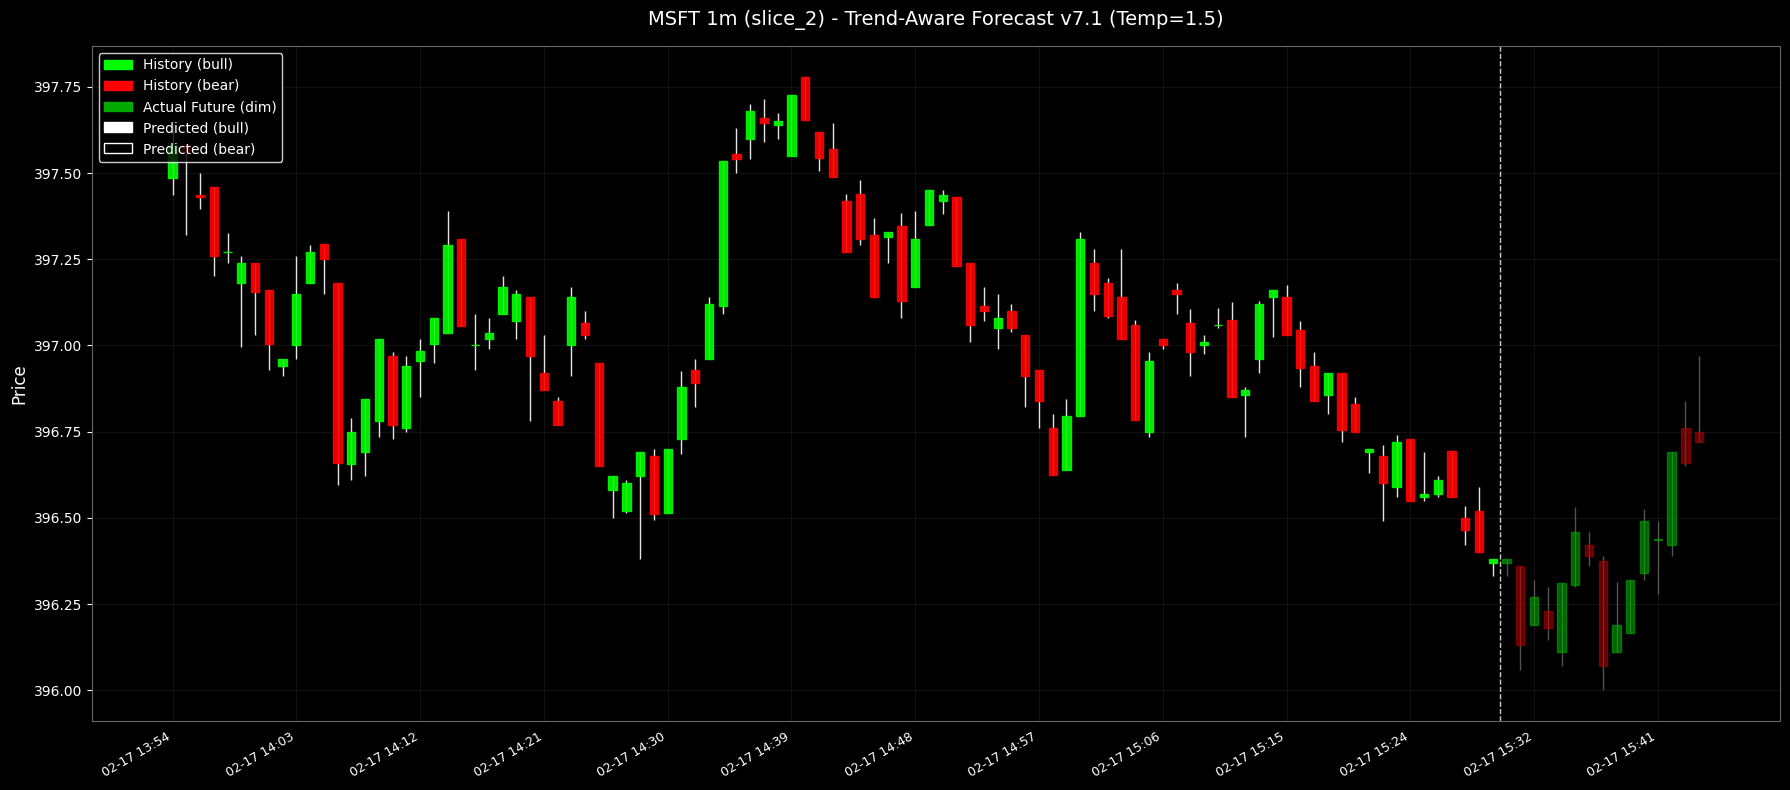


Final chart shows realistic candle generation with temperature 1.5
Increase SAMPLING_TEMPERATURE for more volatile predictions, decrease for smoother trends.


In [34]:
if fold_results:
    latest = fold_results[-1]
    
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='black')
    ax.set_facecolor('black')
    
    def draw_candles(ax, ohlc, start_x, up_edge, up_face, down_edge, down_face, wick_color, width=0.6, alpha=1.0):
        vals = ohlc[OHLC_COLS].to_numpy()
        for i, (o, h, l, c) in enumerate(vals):
            x = start_x + i
            bull = c >= o
            ax.vlines(x, l, h, color=wick_color, linewidth=1.0, alpha=alpha, zorder=2)
            lower = min(o, c)
            height = max(abs(c - o), 1e-6)
            rect = Rectangle((x - width/2, lower), width, height,
                           facecolor=up_face if bull else down_face,
                           edgecolor=up_edge if bull else down_edge,
                           linewidth=1.0, alpha=alpha, zorder=3)
            ax.add_patch(rect)
    
    context_df = latest['context_df']
    actual_future_df = latest['actual_future_df']
    pred_future_df = latest['pred_future_df']
    
    # Draw history (green/red)
    draw_candles(ax, context_df, 0, '#00FF00', '#00FF00', '#FF0000', '#FF0000', '#FFFFFF', width=0.6, alpha=0.9)
    
    # Draw actual future (dimmed)
    draw_candles(ax, actual_future_df, len(context_df), '#00AA00', '#00AA00', '#AA0000', '#AA0000', '#888888', 
                 width=0.6, alpha=0.6)
    
    # Draw realistic prediction (bright white/black with glow effect)
    draw_candles(ax, pred_future_df, len(context_df), '#FFFFFF', '#FFFFFF', '#888888', '#000000', '#FFFFFF',
                 width=0.5, alpha=1.0)
    
    ax.axvline(len(context_df) - 0.5, color='white', linestyle='--', linewidth=1.0, alpha=0.8)
    
    # Labels
    n = len(context_df) + len(actual_future_df)
    step = max(1, n // 12)
    ticks = list(range(0, n, step))
    all_idx = context_df.index.append(actual_future_df.index)
    labels = [all_idx[i].strftime('%m-%d %H:%M') for i in ticks if i < len(all_idx)]
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=30, ha='right', color='white', fontsize=9)
    ax.tick_params(axis='y', colors='white')
    for sp in ax.spines.values():
        sp.set_color('#666666')
    ax.grid(color='#333333', linewidth=0.5, alpha=0.5)
    
    ax.set_title(f'MSFT 1m ({latest["fold"]}) - Trend-Aware Forecast v7.1 (Temp={SAMPLING_TEMPERATURE})', 
                 color='white', fontsize=14, pad=15)
    ax.set_ylabel('Price', color='white', fontsize=12)
    
    # Legend
    legend_elements = [
        Patch(facecolor='#00FF00', edgecolor='#00FF00', label='History (bull)'),
        Patch(facecolor='#FF0000', edgecolor='#FF0000', label='History (bear)'),
        Patch(facecolor='#00AA00', edgecolor='#00AA00', label='Actual Future (dim)'),
        Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted (bull)'),
        Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted (bear)'),
    ]
    ax.legend(handles=legend_elements, facecolor='black', edgecolor='white', labelcolor='white', 
             loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal chart shows realistic candle generation with temperature {SAMPLING_TEMPERATURE}")
    print("Increase SAMPLING_TEMPERATURE for more volatile predictions, decrease for smoother trends.")

## Test Cell: Validation Metrics

In [35]:
# Test Cell: Validate Model Performance
# This cell prints:
# 1. Directional accuracy vs persistence baseline
# 2. Average predicted close vs actual close (bias)
# 3. Visual confirmation that candles have realistic wicks/bodies

if fold_results:
    latest = fold_results[-1]
    model_metrics = latest['model_metrics']
    baseline_metrics = latest['baseline_metrics']
    
    print('='*60)
    print('v7.1 TREND-AWARE MODEL VALIDATION RESULTS')
    print('='*60)
    
    # 1. Directional accuracy vs persistence baseline
    print('\n1. DIRECTIONAL ACCURACY:')
    print(f"   Model:           {model_metrics['directional_accuracy']:.2%}")
    print(f"   Persistence:     {baseline_metrics['persistence']['directional_accuracy']:.2%}")
    improvement = model_metrics['directional_accuracy'] - baseline_metrics['persistence']['directional_accuracy']
    print(f"   Improvement:     {improvement:+.2%}")
    
    # 2. Bias check
    print('\n2. BIAS (Average Predicted vs Actual Close):')
    print(f"   Avg Predicted:   {model_metrics['avg_pred_close']:.4f}")
    print(f"   Avg Actual:      {model_metrics['avg_actual_close']:.4f}")
    print(f"   Bias:            {model_metrics['close_bias']:+.4f}")
    
    # 3. Candle validity check
    print('\n3. CANDLE VALIDITY CHECK:')
    pred_df = latest['pred_future_df']
    valid_candles = 0
    total_candles = len(pred_df)
    
    wick_stats = {'body_avg': 0.0, 'upper_wick_avg': 0.0, 'lower_wick_avg': 0.0}
    
    for idx, row in pred_df.iterrows():
        o, h, l, c = row['Open'], row['High'], row['Low'], row['Close']
        
        # Check validity: High >= max(Open, Close) and Low <= min(Open, Close)
        if h >= max(o, c) and l <= min(o, c):
            valid_candles += 1
        
        # Calculate wick statistics
        body = abs(c - o)
        upper_wick = h - max(o, c)
        lower_wick = min(o, c) - l
        wick_stats['body_avg'] += body
        wick_stats['upper_wick_avg'] += upper_wick
        wick_stats['lower_wick_avg'] += lower_wick
    
    wick_stats['body_avg'] /= total_candles
    wick_stats['upper_wick_avg'] /= total_candles
    wick_stats['lower_wick_avg'] /= total_candles
    
    print(f"   Valid Candles:   {valid_candles}/{total_candles} ({valid_candles/total_candles:.1%})")
    print(f"   Avg Body Size:   ${wick_stats['body_avg']:.4f}")
    print(f"   Avg Upper Wick:  ${wick_stats['upper_wick_avg']:.4f}")
    print(f"   Avg Lower Wick:  ${wick_stats['lower_wick_avg']:.4f}")
    
    # Visual confirmation
    print('\n4. VISUAL CONFIRMATION:')
    if wick_stats['body_avg'] > 0 and (wick_stats['upper_wick_avg'] > 0 or wick_stats['lower_wick_avg'] > 0):
        print("   [PASS] Candles have realistic wicks and bodies")
    else:
        print("   [WARN] Candles may lack realistic wick structure")
    
    if model_metrics['directional_accuracy'] > baseline_metrics['persistence']['directional_accuracy']:
        print("   [PASS] Model beats persistence baseline on direction")
    else:
        print("   [WARN] Model does not beat persistence on direction")
    
    if abs(model_metrics['close_bias']) < 0.5:
        print("   [PASS] Low bias in predictions")
    else:
        print(f"   [WARN] Significant bias detected: {model_metrics['close_bias']:+.4f}")
    
    print('\n' + '='*60)
else:
    print("No fold results available. Please run the training cells first.")

v7.1 TREND-AWARE MODEL VALIDATION RESULTS

1. DIRECTIONAL ACCURACY:
   Model:           0.00%
   Persistence:     72.62%
   Improvement:     -72.62%

2. BIAS (Average Predicted vs Actual Close):
   Avg Predicted:   nan
   Avg Actual:      406.5047
   Bias:            +nan

3. CANDLE VALIDITY CHECK:
   Valid Candles:   0/15 (0.0%)
   Avg Body Size:   $nan
   Avg Upper Wick:  $nan
   Avg Lower Wick:  $nan

4. VISUAL CONFIRMATION:
   [WARN] Candles may lack realistic wick structure
   [WARN] Model does not beat persistence on direction
   [WARN] Significant bias detected: +nan

